# Stamp Tutorial

11/26/2024

*Noah Stiegler - SETI Institute Intern Fall 2024 under Mentor Dr. Chenoa Tremblay*


When COSMIC finds something which looks like a technosignature, it saves a small record of that detection as a *hit* including where on the sky and in the spectrum the signal was found, as well as a few details about it like strength and drift rate. These hits are helpful logs of everything COSMIC finds, and, because they're so small, they don't take up too much space in storage. However, we can't tell from the detection criteria whether a genuine technosignature produced the hit or if RFI (radio frequency interference) confused the algorithm. If we could look at the dynamic spectra, we could determine by eye whether something is promising, however COSMIC can't save every dynamic spectra it takes (to protect the science of the observers it commensally collects from and because we would quickly run out of storage). Instead, COSMIC saves small cutouts of the dynamic spectra around the most promising hits for later review by eye. Because they're small, like postage stamps, we call these *stamps*. The set of signals which produce stamps is a subset of the signals which generate hits. We expect every stamp to correspond to a hit, but not every hit gets a stamp.


Stamps are usually stored in folders with the hits recorded from a particular observation. Below you can see some example data. The files which end in .hits and .stamps hold the hits and stamps respectively. Because hits are small, they're usually all stored in the same file, but if there are a lot of stamps from an observation they may be split into multiple stamp files, ordered `0000`, `0001`, etc. The .`bfr5` file holds the 'beamformer recipe' which tells us how the raw data was beamformed on a particular target a a particular location. The `.txt` file holds the logged output from BLADE (which does the beamforming).

In [1]:
# Look at what's in this folder
import os
DIR = os.getcwd()
print("This is an example folder with hits and stamps")
print('-'*80)
!ls

This is an example folder with hits and stamps
--------------------------------------------------------------------------------
README.md     example.raw.blade.stdout.txt	example.raw.seticore.hits
example.bfr5  example.raw.seticore.0000.stamps	stamp_tutorial.ipynb


Stamps (and hits for that matter) are encoded using a custom scheme (capnp), and so require the seticore viewer Python package to access. The package can be a little fiddly, but I've had success installing it with Python 3.7. The standard maintained branch is https://github.com/MydonSolutions/seticore. It may need to be pip installed if they're not already. I've included the conda environment this tutorial was written with as `packages.txt` which can be used to recreate the environment with `conda create --name stamp_viewer --file packages.txt`

In [2]:
# Try to import the seticore viewer
try:
    from seticore import viewer
except:
    # May need to install pycapnp
    try:
        %pip install pycapnp
    except:
        %conda install pycapnp
   
   # May need to install seticore Python
    %pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
    from seticore import viewer

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/nstiegle


If that worked, we're ready to load in and look at some stamps! Looking at stamps properly requires using the beamformer file the dynamic spectra was originally generated with, so we tell the viewer to look for it in the folder (I believe it looks for .brf5 files with the same name).

In [3]:
# Load in the stamps (with recipes in bfr5 file with the same name in the 
# same location) and make sure they all got read in correctly

# Define where the stamps are being held
STAMPS_PATH = os.path.join(DIR, "example.raw.seticore.0000.stamps")
print(f"Stamps should be at: {STAMPS_PATH}")

# Use the viewer to load the stamps. stamps_gen is a 'generator' object which
# you can iterate through (but not index into). Here, I belive the stamps 
# aren't really loaded, but their headers/metadata are stored so they
# can be found and loaded in later when we want the data in them.
# I put all the stamps into a list so I can index them
stamps_gen = viewer.read_stamps(STAMPS_PATH, find_recipe=True)
stamps = []
for stamp in stamps_gen:
    # Put stamp in list
    stamps.append(stamp)
    
    # Check stamp got loaded correctly
    assert(stamp != None) # Assert throws an error if the condition is False
    assert(stamp.recipe != None)

# Check how many were in the file
print("Found:", len(stamps), "stamps")

Stamps should be at: /home/nstiegle/COSMIC_stamp_tutorial/example.raw.seticore.0000.stamps
Found: 60 stamps


Let's take a look at what's in a stamp object! Each one holds the data in the 'stamp' member and information about the recipe in the 'recipe' member.

In [ ]:
# Get one stamp from the list
stamp = stamps[0]

# Let's look at what's in the 'stamp' data! This can get long, so I've commented
# out the print statement to make it easier to upload to GitHub
# When '.stamp' is called, it actually loads in all the data so this can 
# take a moment
# print(stamp.stamp) # <----- UNCOMMENT IF YOU WANT TO TRY

# Here's what you'll see:
# ( sourceName = "HerBS108",
#   ra = 8.63818611117221,        # RA coordinate
#   dec = -0.69299999906489251,   # Dec coordinate
#   fch1 = 24150.197318458555,    # Frequency of 1st stamp channel in MHz
#   foff = 1.9073486328125e-06,   # Offset between fine channels in MHz
#   tstart = 1702816003.4131095,  # Time of 1st spectra (in MJD I think but not 100% certain)
#   tsamp = 0.524288,             # Time each spectra integrated for
#   telescopeId = 0,              # I think 0 is the ATA or something, but this is COSMIC data
#   numTimesteps = 16,            # How many spectra/integrations are in the file (time-dimension)
#   numChannels = 524,            # Number of fine channels (each with foff width)
#   numPolarizations = 2,         # Two polarizations per observation
#   numAntennas = 25,             # Here I guess 2 antennas were down for maintenance
#   data = [LOTS OF DATA HERE, THIS TAKES FOREVER TO LOAD] 
#   seticoreVersion = "0.0.0.a",
#   coarseChannel = 0,            # Which of the (32?) coarse channels the stamp is from
#   fftSize = 524288,             # Size of coarse channel?
#   startChannel = 155880,        # Channel number of fch1 in coarse channel
#   signal = (                    ## Data about the hit the stamp was made for ##
#     frequency = 24150.197...,   # Frequency of the bin the signal started in
#     index = 156142,             # Which fine channel (in the coarse channel)
#     driftSteps = 0,             # Amount of fine channels signal drifted 
#     driftRate = 0,              # Drift rate in Hz/s
#     snr = 437.06461,            # Signal to noise ratio of the hit
#     coarseChannel = 0,          # Which of the (32?) coarse channels the hit is in
#     beam = 1,                   # Which of the beamformed beams the hit is in
#     numTimesteps = 16,          # How many spectra/integrations are in the file (time-dimension)
#     power = 2.4137146e13,       # Integrated power? (arbitrary units?)
#     incoherentPower = 0 ),      # Power of the signal in the incoherent beam?
#   schan = 0,
#   obsid = "Unknown" )

# Look at what's in the recipe of a stamp file
# def print_recipe(stamp):
#     recipe = stamp.recipe
#     print("h5", recipe.h5)
#     print("ras", recipe.ras)
#     print("decs", recipe.decs)
#     print("obsid", recipe.obsid)
#     print("src_names", recipe.src_names)
#     print("time_array", recipe.time_array)
#     print("npol", recipe.npol)
#     print("nbeams", recipe.nbeams)
#     print("cal_all", recipe.cal_all)
#     print("nants", recipe.nants)
#     print("nchan", recipe.nchan)

# print_recipe(stamp) <--- UNCOMMENT IF YOU WANT TO TRY
# output:
# h5 <HDF5 file "example.bfr5" (mode r)>
# ras [2.2616151]                                                          # RA of beam
# decs [-0.01221137]                                                       # Dec of beam
# obsid b'23B-169.sb44907755.eb44921564.60295.44951556713.34.1'            # Observation ID
# src_names [b'3073619025268414208']                                       # GAIA name of source
# time_array [1.70281600e+09 1.70281600e+09 1.70281600e+09 1.70281600e+09  # Array of times (I belive in BJD)
# ...
#  1.70281606e+09 1.70281606e+09 1.70281606e+09 1.70281606e+09]
# npol 2                                                                   # Number of polarizations
# nbeams 1                                                                 # Number of beams (low at high frequencies)
# cal_all [[[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]                # Not sure what this is - possibly calibration?
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]
#  [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]
#  [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]
#  ...
#  [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]
#  [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]
#  [[1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
#   [1.+0.j 1.+0.j 1.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]]
# nants 25                                                                # Number of antennas of the observation
# nchan 448                                                               # Number of channels of the stamp?

You may want to scan through all the stamps in a stamp file to find one which matches a particular hit. 

In [ ]:
# You can get out the metadata of all the stamps in the file like this:
frequencies = [stamp.stamp.signal.frequency for stamp in stamps]
drift_rates = [stamp.stamp.signal.driftRate for stamp in stamps]
snrs = [stamp.stamp.signal.snr for stamp in stamps]
powers = [stamp.stamp.signal.power for stamp in stamps]
incoherent_powers = [stamp.stamp.signal.incoherentPower for stamp in stamps]

# Look at what's in the signal to noise ratios that were saved for each stamp
print(snrs)

[437.0646057128906, 358.3106689453125, 200.64027404785156, 91.32572174072266, 68.14472198486328, 48.65808868408203, 40.94623565673828, 26.385210037231445, 23.235729217529297, 18.80293846130371, 17.410757064819336, 15.290722846984863, 14.779956817626953, 13.196008682250977, 13.115074157714844, 12.03779125213623, 10.386115074157715, 8.071824073791504, 8.006415367126465, 8.033697128295898, 8.148139953613281, 8.55778980255127, 19.012487411499023, 26.249794006347656, 8.070815086364746, 8.964582443237305, 8.375057220458984, 121.60802459716797, 40.72726058959961, 19.49356460571289, 8.058167457580566, 8.003373146057129, 8.549844741821289, 8.130144119262695, 8.315170288085938, 8.014382362365723, 8.032727241516113, 8.359009742736816, 8.173542022705078, 244.17086791992188, 82.24148559570312, 79.49380493164062, 77.8885269165039, 55.922645568847656, 43.73468017578125, 37.118316650390625, 32.81803894042969, 31.39529800415039, 29.82964324951172, 29.092065811157227, 28.00444984436035, 25.9507045745849

So now that we understand the files, let's look at the dynamic spectra, the whole point of stamps!

First, let's look at the incoherent beam, which kind of 'averages' the sensitivity to the center of the observing area

recalculated power: 2.413714e+13
local SNR: 1910.900259898222


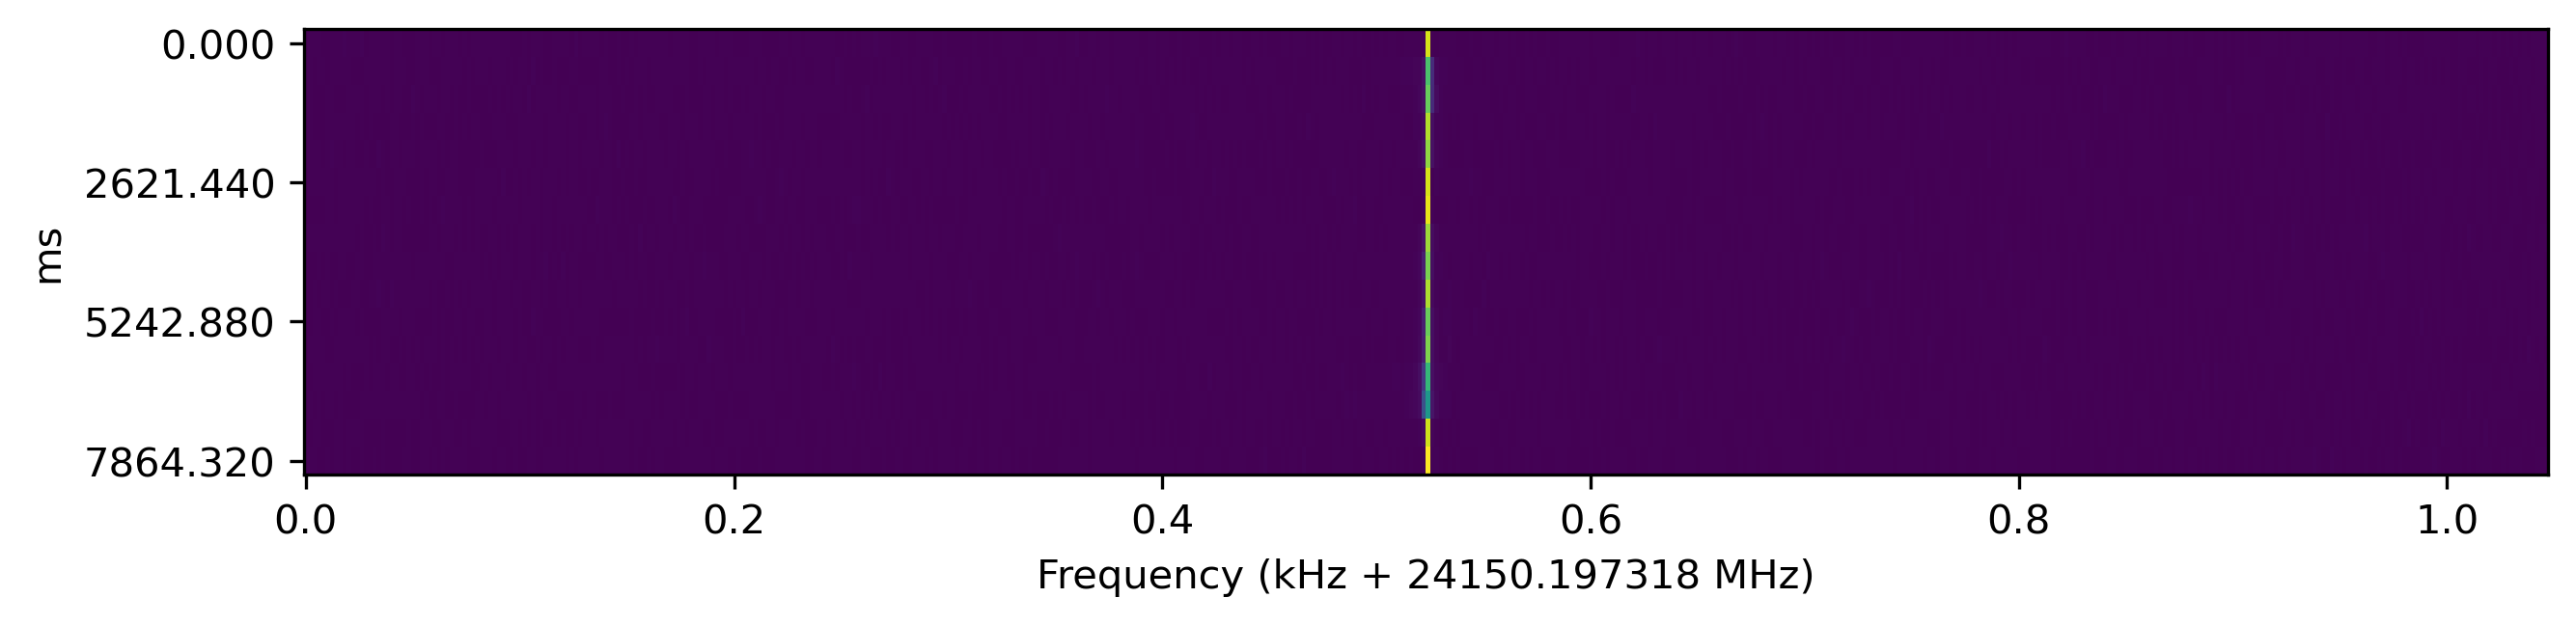

recalculated power: 2.413714e+13
local SNR: 1910.9002598982213


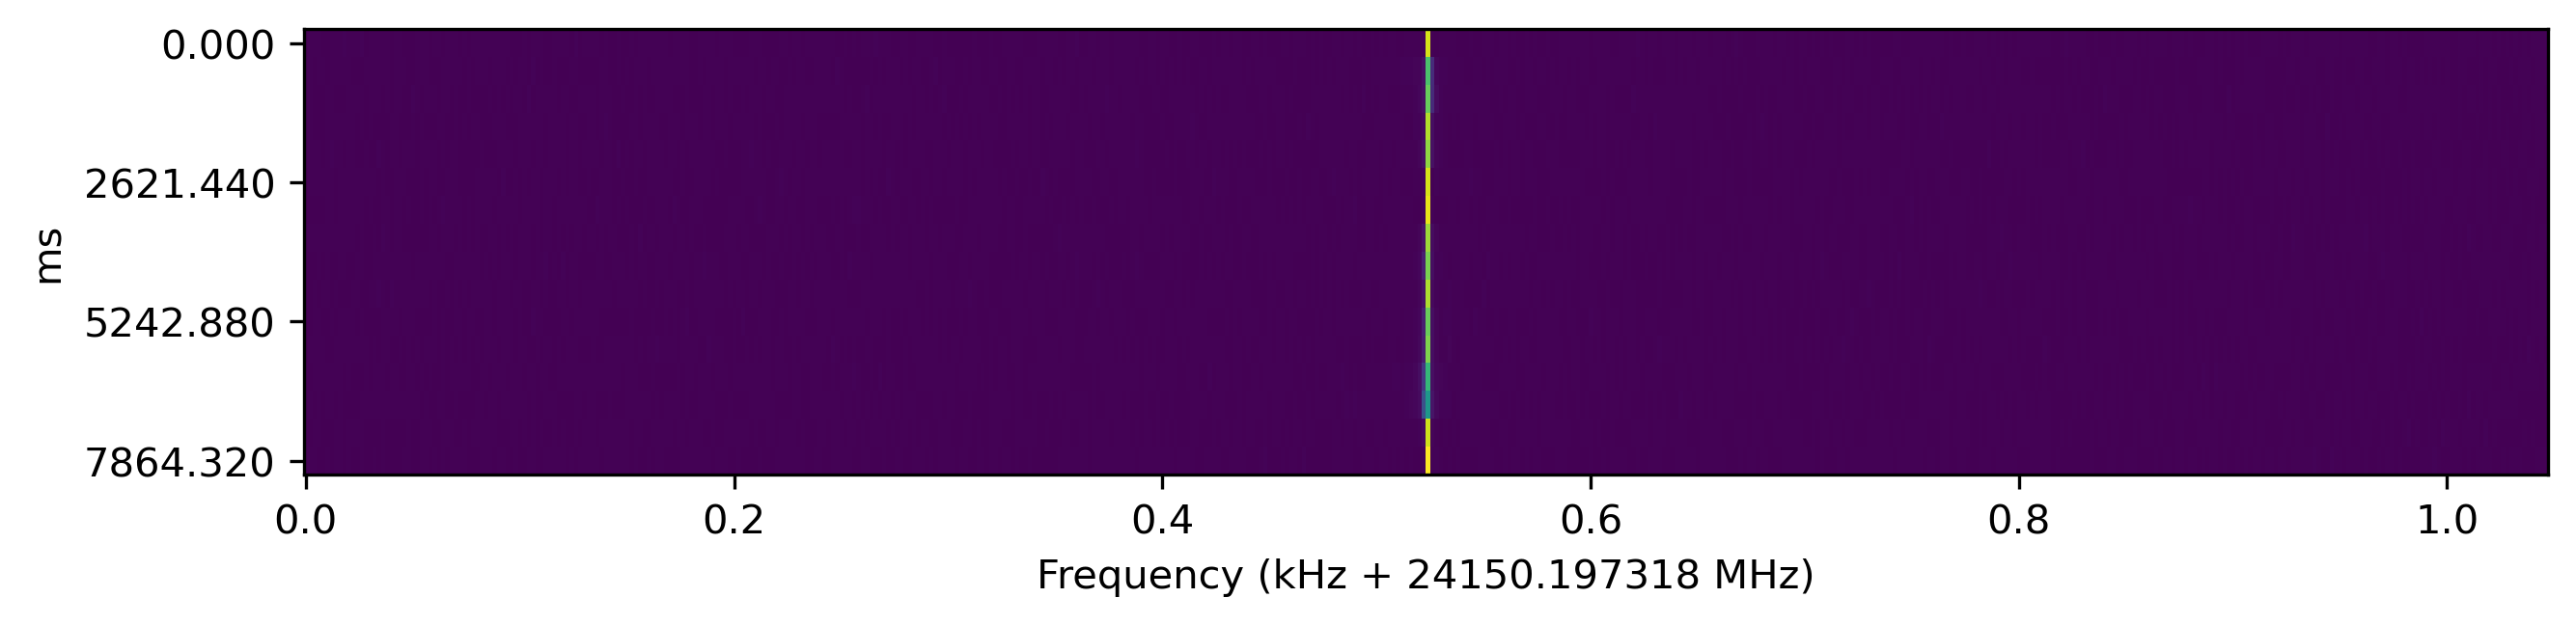

In [ ]:
# There are 2 ways to do this with the python viewer, but I don't really
# understand the difference between them
stamp.show_classic_incoherent()
stamp.show_weighted_incoherent()

You might notice that the 'local SNR' is printed. This isn't the SNR of the hit that's stored in the hit and the stamp, but  rather a local re-calculation. The signal itself is the sum of the pixels along the calculated drift line (a sum of n_timesteps intensities).

recalculated power: 2.413714e+13
local SNR: 1910.900259898222


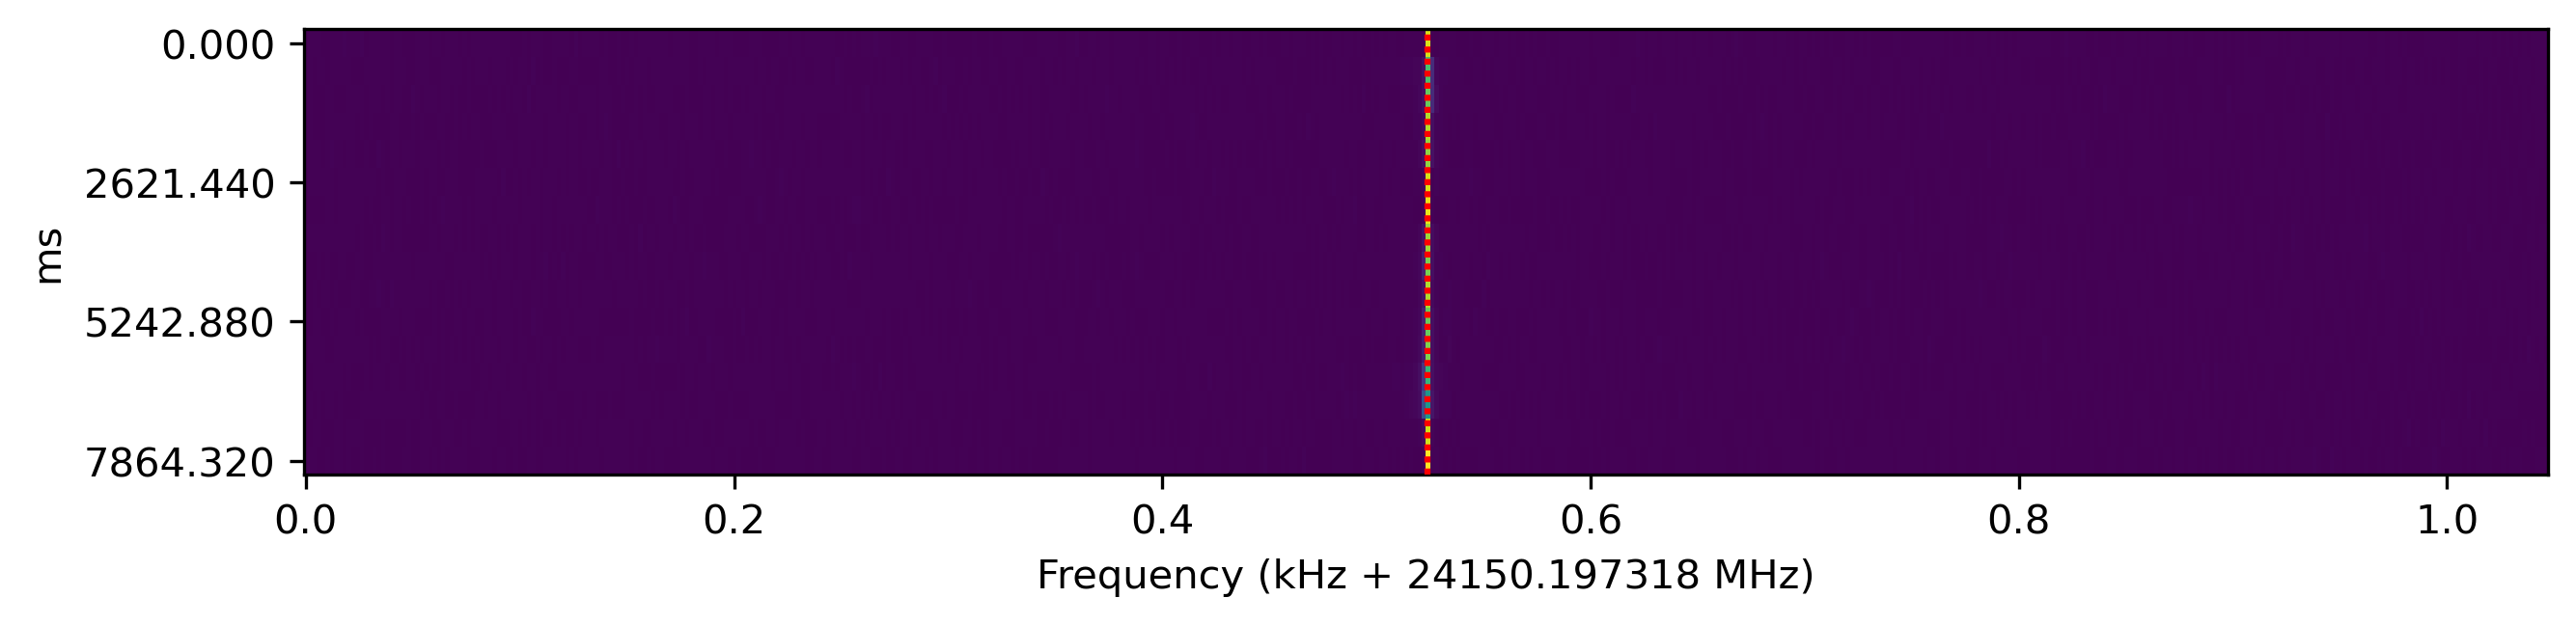

In [66]:
# Let's plot that line (it may be hard to see but it's a red dashed line through the signal)
stamp.show_classic_incoherent(show_signal=True)

The first and last 20 fine-channels (columns) of data are taken to be the
background noise for the local SNR calculation. These columns are summed
in time (adding n_timesteps intensities) and the result is averaged together.
This nosie floor is subtracted from the signal. The standard deviation of the
summed 20-most left and right columns is taken to be the variance of the noise.
The amount the signal is above the noise floor is divided by this standard
deviation to get the SNR according to this formula:
$(signal\_sum - noise\_sum\_average) / noise\_sum\_standard\_deviation$

This recalculated SNR usually doesn't match the SNR saved by the hit because
that SNR is calculated differently

If you want to look at the coherent beam(s) the hits are from, you can do that too:

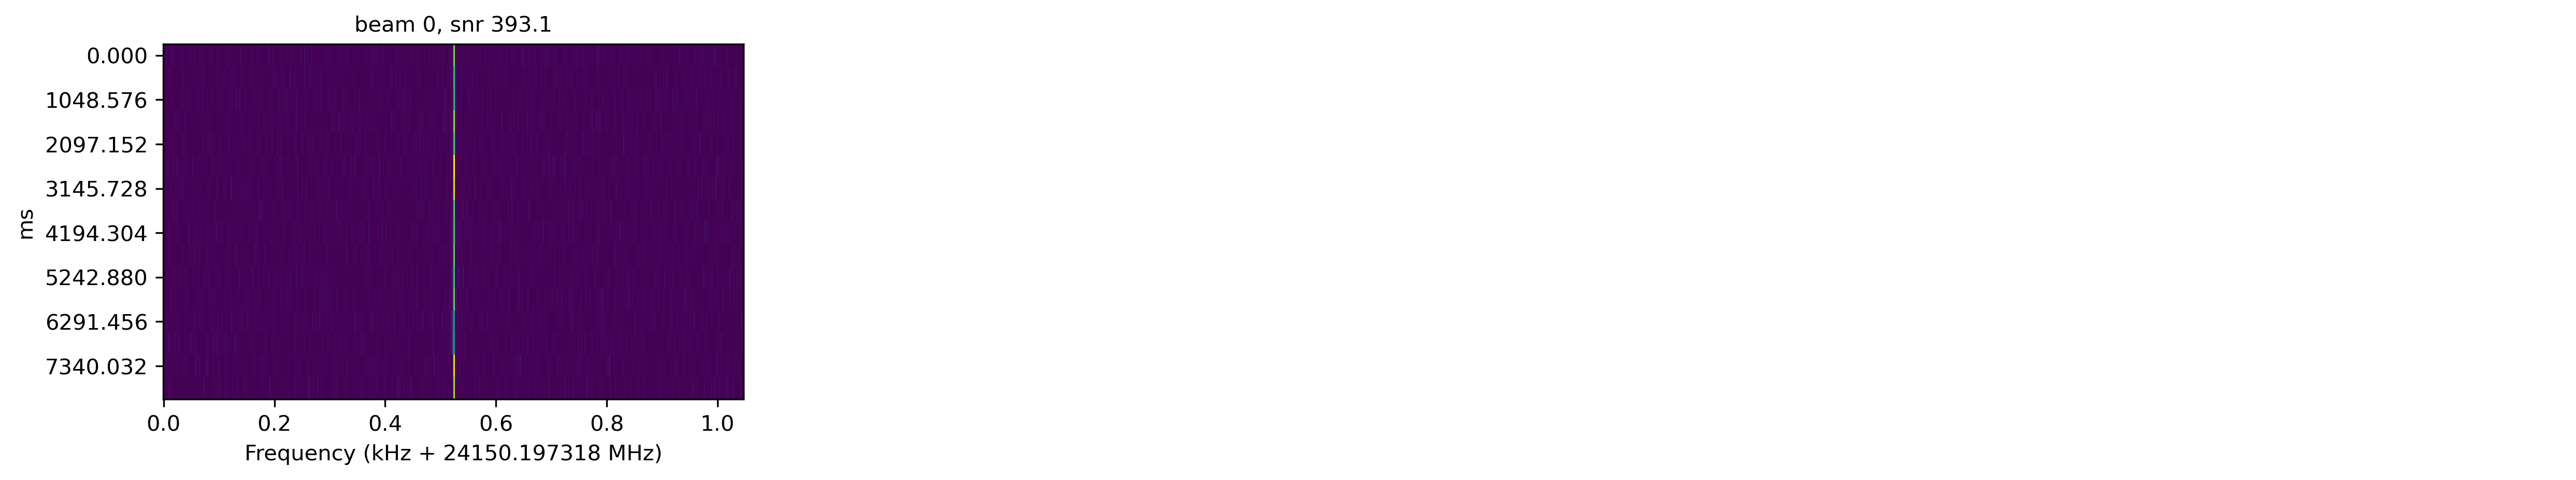

recalculated power: 2.511129e+13
local SNR: 393.05296397755814


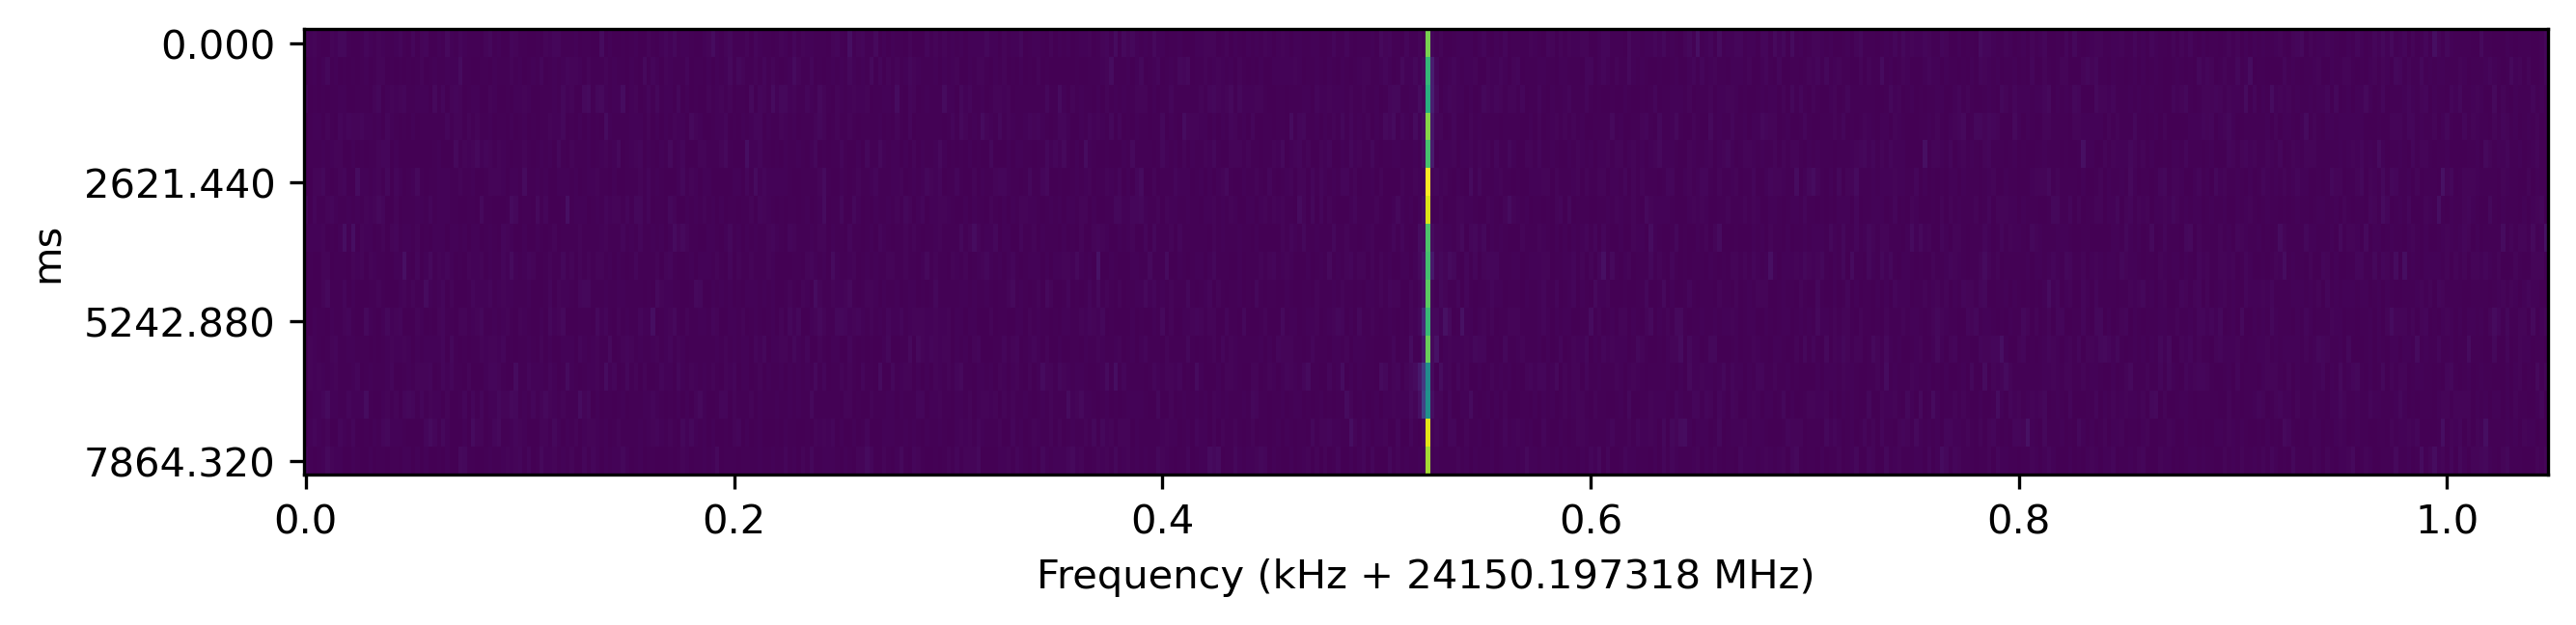

In [ ]:
stamp.show_beams() # Look at all of them
stamp.show_beam(0) # Look at a specific one, 0 indexed (-1 works to get last beam)

A great thing about stamps is that the data from each individual antenna is saved and can be inspected later.

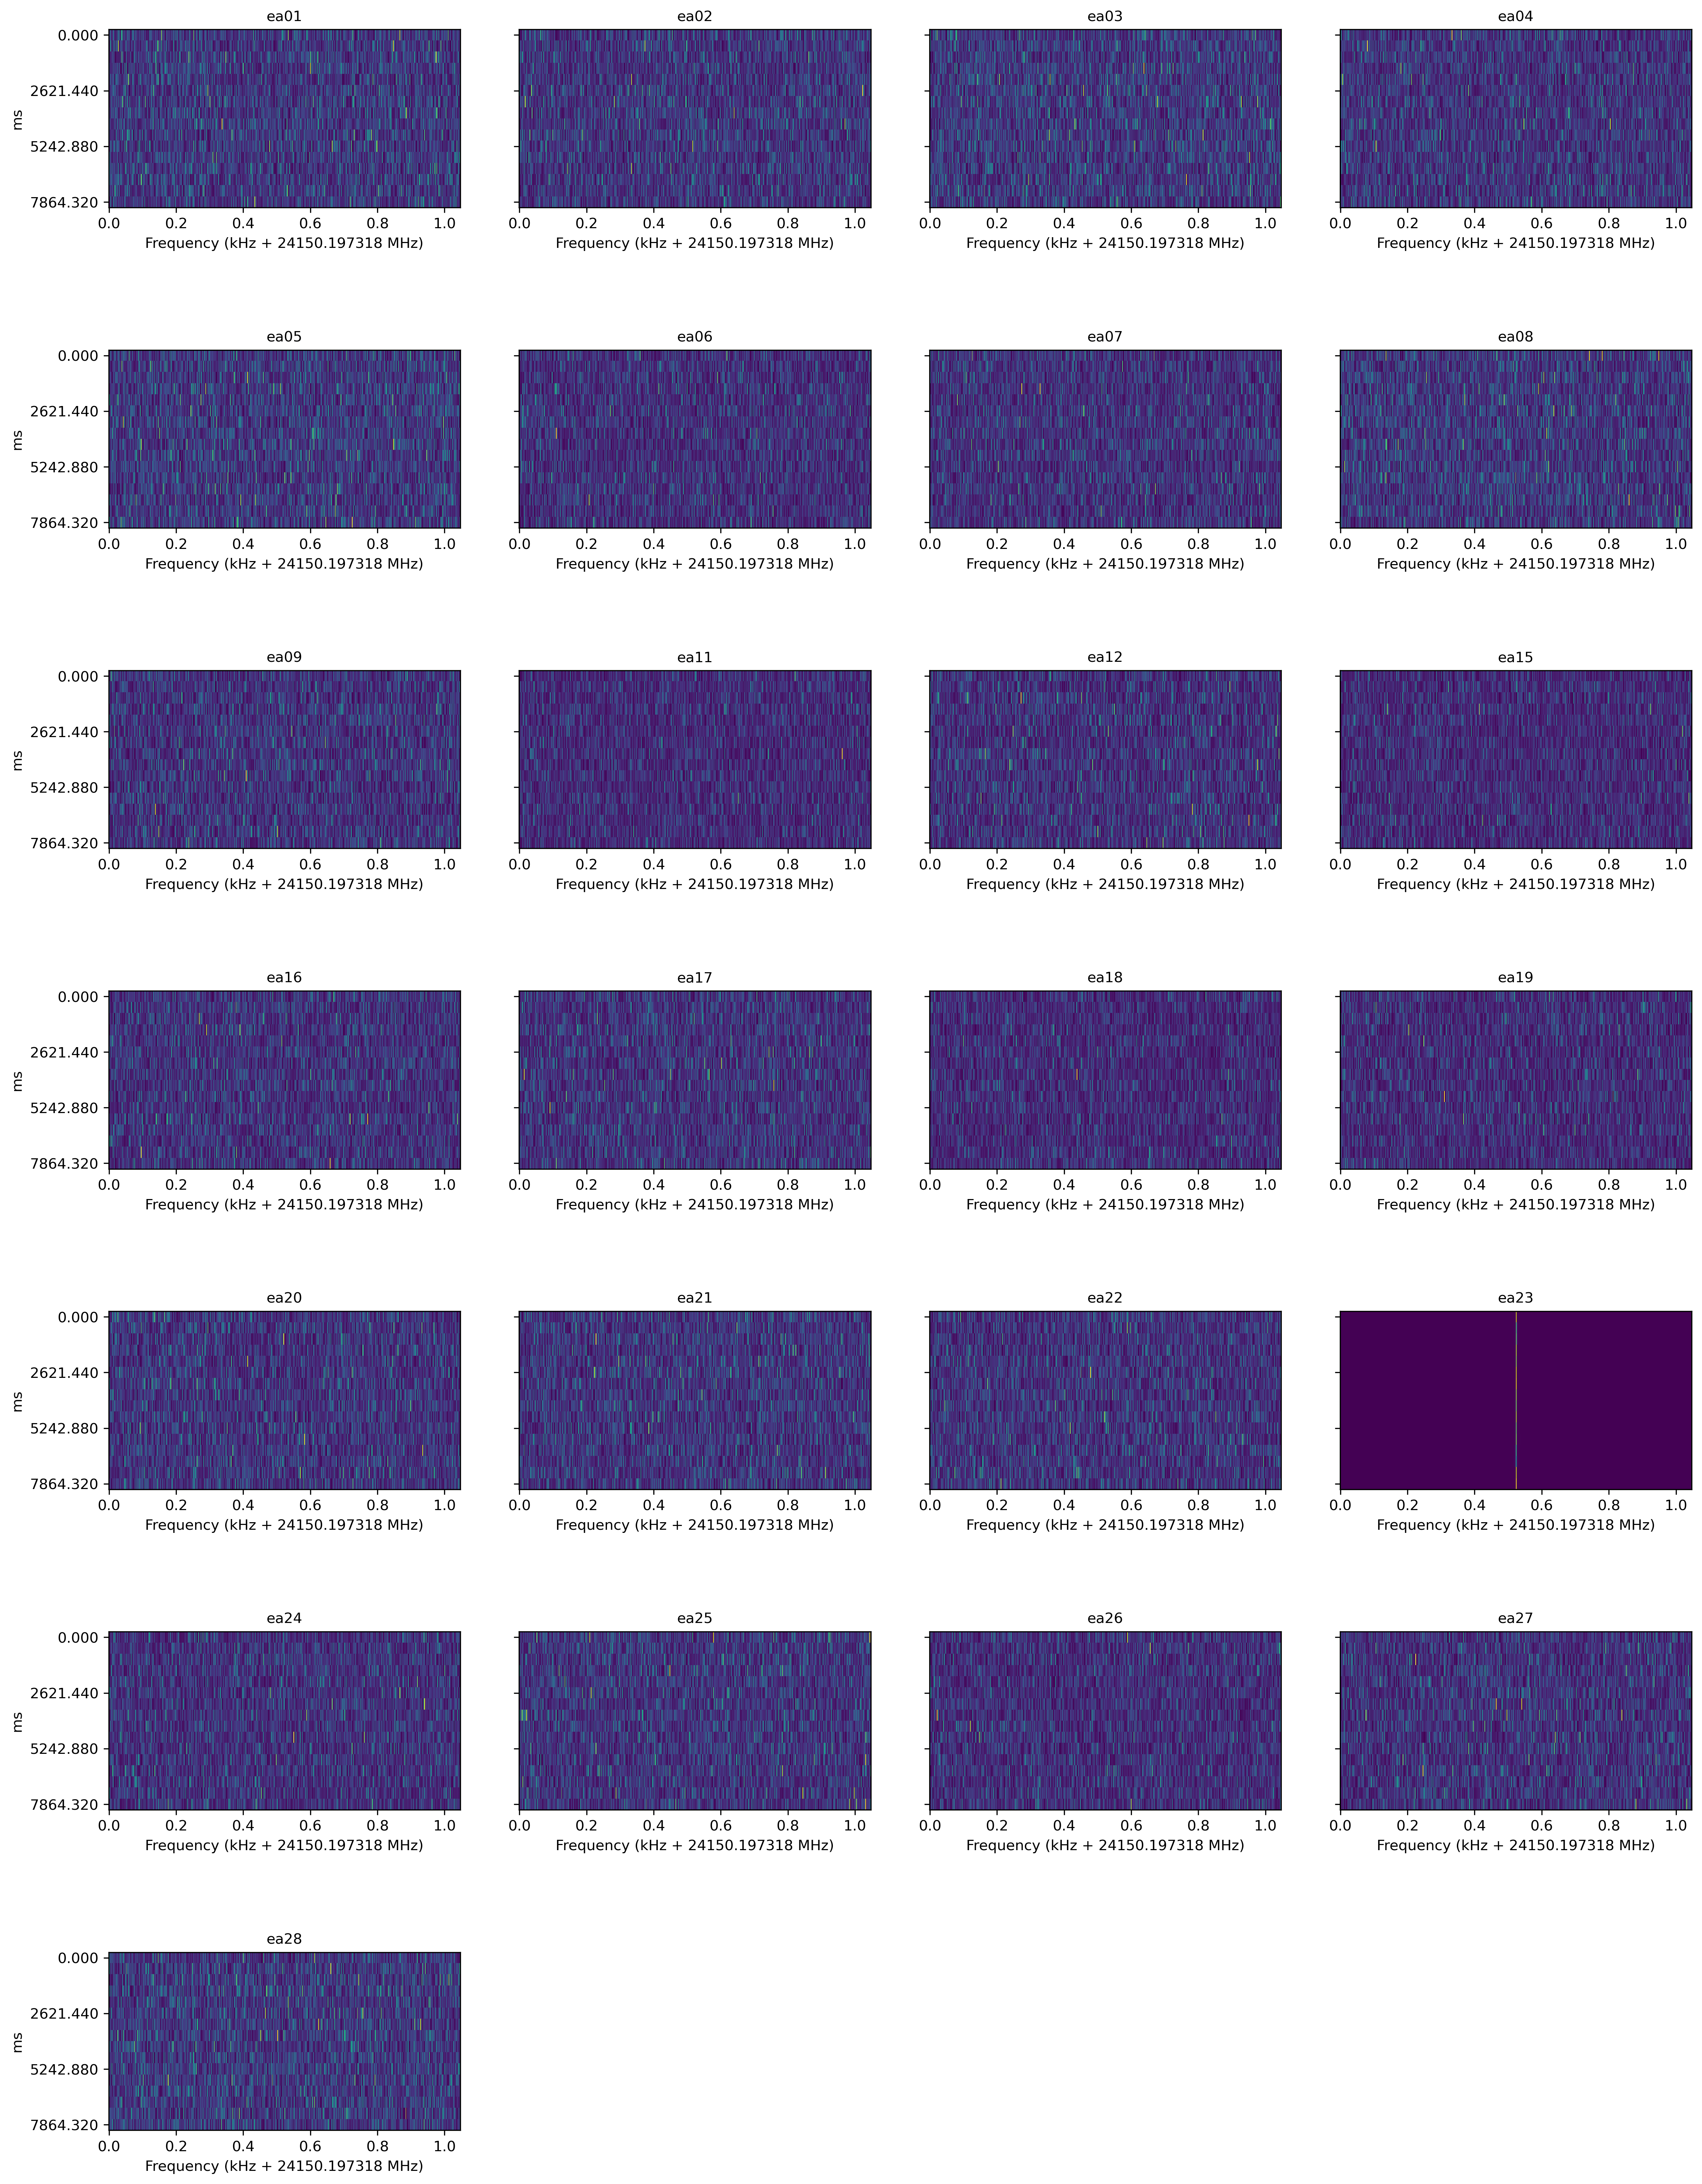

In [67]:
# Let's look at the by-antenna data from this stamp
stamp.show_antennas()

You can see that the signal is only coming from 1 antenna - a sure sign
of RFI!


You can also look at one antenna individually

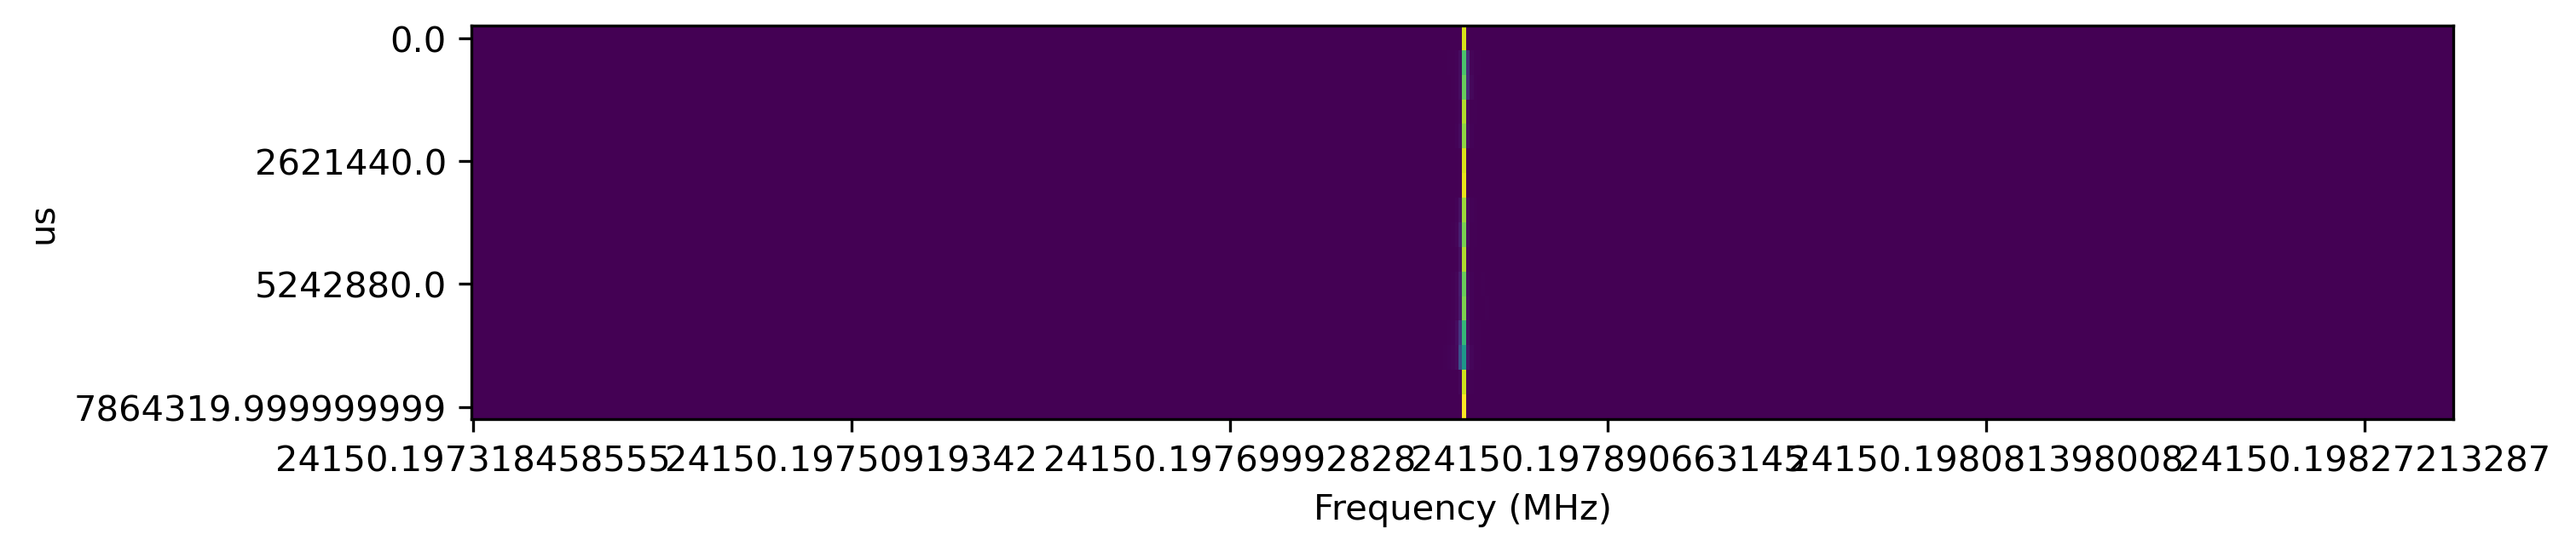

In [ ]:
# Look at one antenna
# This indexes antennas based on where they show up in the grid from show_antennas()
# with the top left antenna being antenna 0 (and the one with the signal being antenna 19)
stamp.show_antenna(19)


You can get the names of the antennas (which are displayed above the individual antennas) 
from the recipe file also

In [69]:
# The ordering of the antenna titles is the same as the ordering of the antennas
antenna_titles = [stamp.recipe.antenna_names[i] for i in range(stamp.stamp.numAntennas)]

If you want to add a title to the plots or save them, you can do that also

In [ ]:
# The below lines show how the different methods of plotting can be passed parameters
stamp.show_classic_incoherent(show_signal=True, title=f"Stamp from Tutorial")
# stamp.show_antenna(0, show_signal=True, title=f"Stamp from Tutorial")
# stamp.show_antennas(show_signal=True, title=f"Stamp from Tutorial")]


If you want to save one of these plots, you can do that too!

In [ ]:
# pass the filepath to save it to in the save_to parameter
# stamp.show_antennas(show_signal=True, title=f"Stamp from Tutorial", save_to=os.path.join(DIR, "example_plot"))

If you want to deal with the data in the stamps yourself, you can also do that

In [70]:
import numpy as np

# This code gets the dynamic spectra data from 'stamp' for each antenna
# The axes 2 and 4 which get summed over are the polarization and complex parts
# of each timestep and channel. We square them because that's how the math works
# out to get intensities (not sure where to find a resource about that)
antenna_powers = np.square(stamp.real_array()).sum(axis=(2, 4)).transpose(2, 0, 1)
print(f"The shape of antenna_powers is {antenna_powers.shape} which is (n_antennas, n_timesteps, n_finechannels)")

The shape of antenna_powers is (25, 16, 524) which is (n_antennas, n_timesteps, n_finechannels)


You can even use the built-in methods of the stamp class to do things like finding the local SNR

The shape of snr_and_signals is (25, 2) which is (antennas, [snrs, signals])


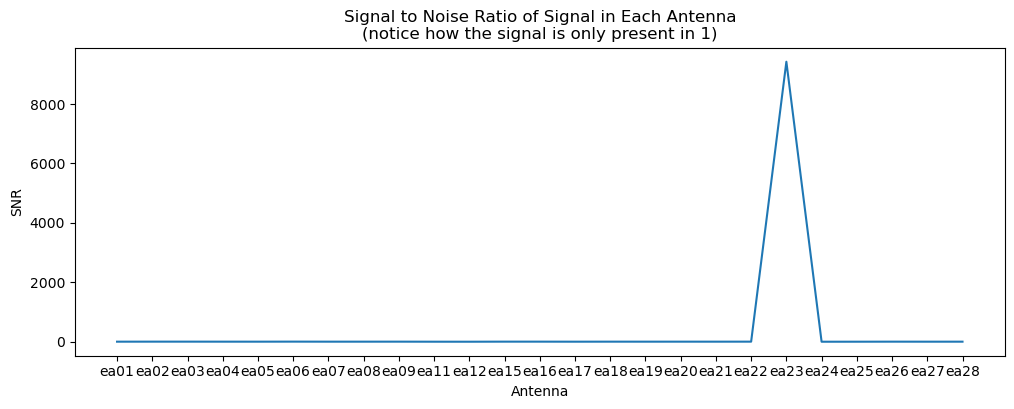

In [ ]:
# Here we can use the built in method from the stamp class which recalculates the
# local SNR and power of the signal in a dynamic spectra
snr_and_signals = np.array([stamp.snr_and_signal(antenna_power) for antenna_power in antenna_powers])
print(f"The shape of snr_and_signals is {snr_and_signals.shape} which is (antennas, [snrs, signals])")

# We can plot the results using matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(antenna_titles, snr_and_signals[:, 0])
plt.title("Signal to Noise Ratio of Signal in Each Antenna\n(notice how the signal is only present in 1)")
plt.xlabel("Antenna")
plt.ylabel("SNR")
plt.show()

You can see how that might be useful for automatically detecting anomalies with or RFI coming from a single antenna